In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import itertools
from matplotlib.patches import Wedge
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

In [2]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B' #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
remote = False
datapath = f'llm-addition/experimentation'


In [3]:
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
NLAYERS = model.config.num_hidden_layers



Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [4]:
def get_nums_hss_solo(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    activations.append(model.transformer.h[layer].inputs[1]['hidden_states'][:,-1].save())
    act = torch.stack(activations).detach().cpu()
    act = act.transpose(0, 1)
    return nums, act


In [5]:
mina = 1
maxa = 360
layer = 10
a, hss = get_nums_hss_solo( mina, maxa)
# Filter out zeros, they cannot be used with log
mask = (a != 0)
hss = hss[mask]
a = a[mask]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [6]:
# PCA decompose and attempt fit against each of them

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

npca = 20


hs = hss[:, layer, :].cpu().float().numpy()
scaler = StandardScaler()
hs_scaled = scaler.fit_transform(hs)

pca = PCA(n_components=npca)
tf = pca.fit_transform(hs_scaled)




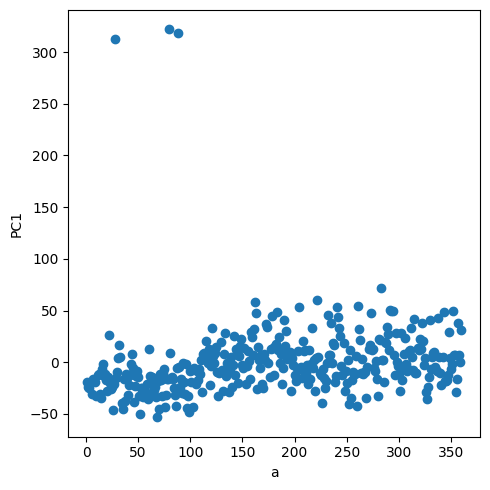

In [7]:
# Plot principal components

import matplotlib.pyplot as plt
# rng = slice(0, 105)
rng = slice(None, None)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs = axs
for i in range(1):
    axs.scatter(a[rng], (tf[:, i][rng]))
    axs.set_xlabel('a')
    axs.set_ylabel(f'PC{i+1}')
plt.tight_layout()
plt.show()

In [99]:
# Feature steering
tokens = torch.tensor(model.tokenizer(f'.')['input_ids'])
steer_strength = 20.00
steer = torch.Tensor(pca.components_[0]) * steer_strength
activations = []
layer = 3
for i in range(50):
    out_tokens = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                model.transformer.h[layer].inputs[1]['hidden_states'][:,-1] += steer
                output = model.output.save()
    # print(act.shape)
    #print(pca.components_[0].shape)
    # Randomly pick a top_k logit
    top_k = 5
    top_k_logits = output.logits[0, -1, :].topk(top_k)
    out_token = top_k_logits.indices[torch.randint(0, top_k, (1,))]


    out_tokens.append(out_token)
    tokens = torch.cat([tokens, torch.tensor([out_token])])
print(model.tokenizer.decode(tokens))

# I played aroud with various strengths, but didn't find anything obvious


. I was in the room, the whole story of the night came rushing back at once: how we met the man with the gun; his threats; my mother's screams, followed immediately after by her silence and my mother, the way the light had
